In [1]:
import astropy
print(astropy.__version__)

from astropy import coordinates
from astropy import time
from astropy import units as u

import numpy as np
from scipy import optimize

1.3


In [2]:
%matplotlib inline

from matplotlib import pyplot as plt

from mpl_toolkits import mplot3d

In [3]:
t = time.Time.now()

In [4]:
loc = coordinates.EarthLocation.of_site('keck')

# Sidereal Day 

In [5]:
stbase = (t - 0.5*u.day).sidereal_time('mean', 0) 
diff = lambda dd:(stbase-(t + (dd-0.5)*u.day).sidereal_time('mean', 0)).value**2
sidereal_day = (optimize.fminbound(diff, .1,2)*u.day).to(u.hour)

# Compute vhelio

In [6]:
_, vsun = coordinates.get_body_barycentric_posvel('sun', t)
_, vearth = coordinates.get_body_barycentric_posvel('earth', t)

In [7]:
sunearth = vearth - vsun
sunearth.xyz.to(u.km/u.s)

<Quantity [-24.03095655,-16.86263115, -7.30886264] km / s>

# Earth surface velocity

In [8]:
veltot = np.sum(loc.get_gcrs_posvel(t)[1].xyz**2)**0.5

r = (loc.x**2+loc.y**2+loc.z**2)**0.5
vc = (2*np.pi*r / sidereal_day).to(u.m/u.s)

vdiff = vc-veltot  # difference between effective circular velocity and true velocity

vdiff, vc *(1-np.cos(loc.geodetic[1]))

(<Quantity 27.30026015734245 m / s>, <Quantity 27.58180983850532 m / s>)

# Vhelio calculation 

In [9]:
def helio_corr(t, loc, target=None):
    """
    The thing you add to a target to get the heliocentric velocity
    """
    vsun = coordinates.get_body_barycentric_posvel('sun', t)[1]
    vearth = coordinates.get_body_barycentric_posvel('earth', t)[1]

    vsunearth = vearth - vsun
    
    gcrs_p, gcrs_v = loc.get_gcrs_posvel(t)
    
    vsuntarg = (vsunearth.xyz + gcrs_v.xyz).to(u.km/u.s)
    if target is None:
        return vsuntarg
    else:
        gtarg = target.transform_to(coordinates.GCRS(obstime=t, obsgeoloc=gcrs_p))
        targxyz = gtarg.represent_as(coordinates.UnitSphericalRepresentation).to_cartesian().xyz
        return coordinates.matrix_utilities.matrix_product(vsuntarg, targxyz)


In [10]:
helio_corr(t, loc)

<Quantity [-23.60550427,-16.96640811, -7.30886264] km / s>

In [11]:
helio_corr(t, loc, coordinates.SkyCoord.from_name('M31'))

-24.619081312584306

# Plot the helio corr over a sphere

In [12]:
npts = 1000

cr = coordinates.CartesianRepresentation(np.random.randn(3, npts), unit=u.dimensionless_unscaled)
usr = cr.represent_as(coordinates.UnitSphericalRepresentation)
cr2 = usr.to_cartesian()  # the points are now uniformly distributed on the sphere

/Users/erik/miniconda3/envs/scratch/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


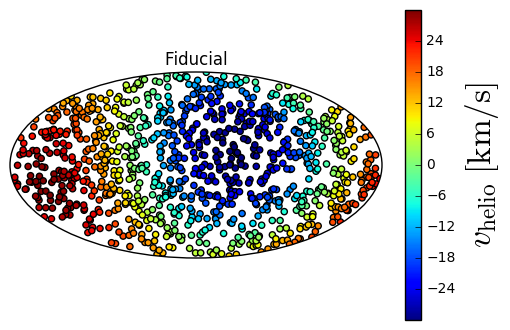

In [13]:
targs = coordinates.SkyCoord(cr2, frame='icrs')
vs = helio_corr(t, loc, targs)

plt.subplot(projection='hammer')
plt.scatter(targs.ra.wrap_at(180*u.deg).rad, targs.dec.rad, c=vs.to(u.km/u.s))
plt.colorbar().set_label(r'$v_{\rm helio} \; [{\rm km/s}]$', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.title('Fiducial')

/Users/erik/miniconda3/envs/scratch/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


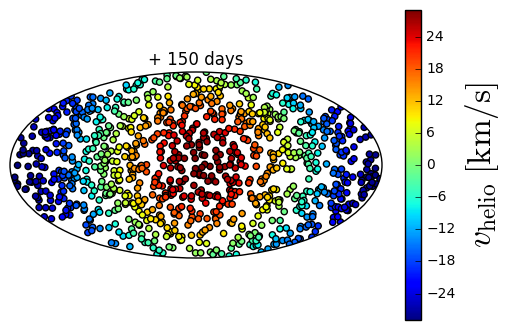

In [14]:
vs = helio_corr(t + 150*u.day, loc, targs)

plt.subplot(projection='hammer')
plt.scatter(targs.ra.wrap_at(180*u.deg).rad, targs.dec.rad, c=vs.to(u.km/u.s))
plt.colorbar().set_label(r'$v_{\rm helio} \; [{\rm km/s}]$', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.title('+ 150 days')

/Users/erik/miniconda3/envs/scratch/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


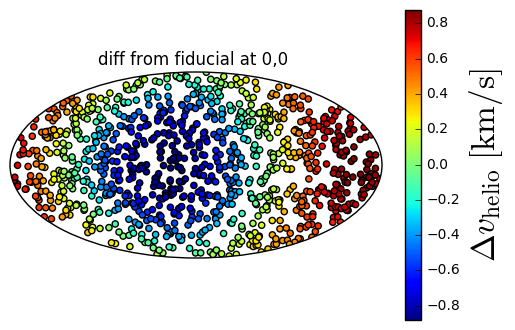

In [15]:
loc2 = coordinates.EarthLocation.from_geodetic(0*u.deg, 0*u.deg)

vs = helio_corr(t, loc, targs)
vs2 = helio_corr(t, loc2, targs)
dvs = vs2-vs

plt.subplot(projection='hammer')
plt.scatter(targs.ra.wrap_at(180*u.deg).rad, targs.dec.rad, c=dvs.to(u.km/u.s))
plt.colorbar().set_label(r'$\Delta v_{\rm helio} \; [{\rm km/s}]$', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.title('diff from fiducial at 0,0 ')

/Users/erik/miniconda3/envs/scratch/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


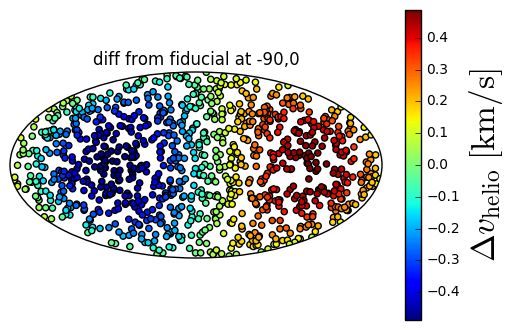

In [16]:
loc2 = coordinates.EarthLocation.from_geodetic(-90*u.deg, 0*u.deg)

vs = helio_corr(t, loc, targs)
vs2 = helio_corr(t, loc2, targs)
dvs = vs2-vs

plt.subplot(projection='hammer')
plt.scatter(targs.ra.wrap_at(180*u.deg).rad, targs.dec.rad, c=dvs.to(u.km/u.s))
plt.colorbar().set_label(r'$\Delta v_{\rm helio} \; [{\rm km/s}]$', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.title('diff from fiducial at -90,0')

/Users/erik/miniconda3/envs/scratch/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


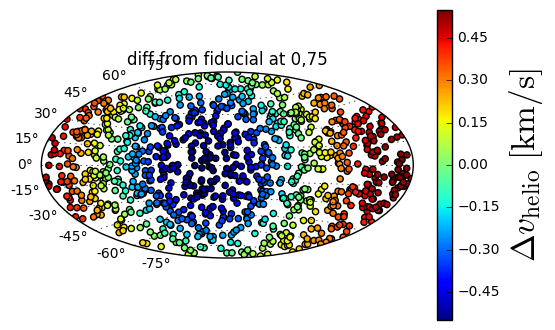

In [17]:
loc2 = coordinates.EarthLocation.from_geodetic(0*u.deg, 75*u.deg)

vs = helio_corr(t, loc, targs)
vs2 = helio_corr(t, loc2, targs)
dvs = vs2-vs

plt.subplot(projection='hammer')
plt.scatter(targs.ra.wrap_at(180*u.deg).rad, targs.dec.rad, c=dvs.to(u.km/u.s))
plt.colorbar().set_label(r'$\Delta v_{\rm helio} \; [{\rm km/s}]$', fontsize=24)
plt.xticks([])
plt.grid(True)
plt.title('diff from fiducial at 0,75')